In [ ]:
!nvidia-smi

Sun Jun  6 15:44:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import json
from IPython.display import Image, display_png
import numpy as np
from numpy.random import seed
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import LabelEncoder
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
from tqdm import tqdm
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers , regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Bidirectional , LSTM, GlobalMaxPool1D
from tensorflow.keras.layers import Dropout,MaxPooling1D,Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding
from tensorflow. keras.layers import Flatten, Dropout, Activation, Input, Dense, concatenate, GRU, Conv1D

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
idx = {251 : 'ประมวลกฎหมายวิธีพิจารณาความแพ่ง 55',
692 : 'ประมวลกฎหมายแพ่งและพาณิชย์ 425',
704 : 'ประมวลกฎหมายแพ่งและพาณิชย์ 438',
154 : 'ประมวลกฎหมายวิธีพิจารณาความแพ่ง 172',
135 : 'ประมวลกฎหมายวิธีพิจารณาความแพ่ง 142',
715 : 'ประมวลกฎหมายแพ่งและพาณิชย์ 448',
688 : 'ประมวลกฎหมายแพ่งและพาณิชย์ 421',
202 : 'ประมวลกฎหมายวิธีพิจารณาความแพ่ง 249',
100 : 'ประมวลกฎหมายวิธีพิจารณาความอาญา 46',
417 :  'ประมวลกฎหมายแพ่งและพาณิชย์ 1336'}

In [ ]:
sorted_idx = list(idx.keys())

In [ ]:
sorted_idx[0:10]

[251, 692, 704, 154, 135, 715, 688, 202, 100, 417]

# Processing data functions

In [ ]:
def process_input(num_words, X_train, X_test, X_dev):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='<UNK>')
    tokenizer.fit_on_texts(X_train)

    #convert text data to numerical indexes
    train_seqs = tokenizer.texts_to_sequences(X_train)
    dev_seqs = tokenizer.texts_to_sequences(X_dev)
    test_seqs = tokenizer.texts_to_sequences(X_test)

    max_sequnce_len = max([len(x) for x in train_seqs])

    train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=max_sequnce_len, padding="post")
    test_seqs=tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=max_sequnce_len, padding="post")
    dev_seqs=tf.keras.preprocessing.sequence.pad_sequences(dev_seqs, maxlen=max_sequnce_len, padding="post")

    return  train_seqs, test_seqs, dev_seqs, max_sequnce_len, tokenizer

In [ ]:
def process_input_combined(num_words, X_train, X_dev, X_test):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, oov_token='<UNK>')
    X_combined = list(X_train[:, 0]) + list(X_train[:, 1])
    tokenizer.fit_on_texts(X_combined)

    #convert text data to numerical indexes
    train_seqs1 = tokenizer.texts_to_sequences(X_train[:, 0])
    train_seqs2 = tokenizer.texts_to_sequences(X_train[:, 1])
    
    dev_seqs1 = tokenizer.texts_to_sequences(X_dev[:, 0])
    dev_seqs2 = tokenizer.texts_to_sequences(X_dev[:, 1])
    
    test_seqs1 = tokenizer.texts_to_sequences(X_test[:, 0])
    test_seqs2 = tokenizer.texts_to_sequences(X_test[:, 1])
    
    max_len = max([len(x) for x in train_seqs1 + train_seqs2])

    train_seqs1 = tf.keras.preprocessing.sequence.pad_sequences(train_seqs1, maxlen=max_len, padding="post")
    test_seqs1=tf.keras.preprocessing.sequence.pad_sequences(test_seqs1, maxlen=max_len, padding="post")
    dev_seqs1 =tf.keras.preprocessing.sequence.pad_sequences(dev_seqs1, maxlen=max_len, padding="post")
    
    train_seqs2 = tf.keras.preprocessing.sequence.pad_sequences(train_seqs2, maxlen=max_len, padding="post")
    test_seqs2=tf.keras.preprocessing.sequence.pad_sequences(test_seqs2, maxlen=max_len, padding="post")
    dev_seqs2 =tf.keras.preprocessing.sequence.pad_sequences(dev_seqs2, maxlen=max_len, padding="post")

    return  train_seqs1, train_seqs2, dev_seqs1, dev_seqs2, test_seqs1, test_seqs2, max_len, tokenizer

In [ ]:
def multi_input_proportional_generator(datasets,
                                       label,
                                       p=[0.1, 0.9],
                                       batch_size=128):
    # p indicate number of class and sampling prob
    while (True):
        batch_data = [[], []]
        batch_label = []
        sample_id = np.random.choice(len(p), batch_size, p=p)
        query_idx = [
            np.where(label == class_id)[0] for class_id in range(len(p))
        ]
        for class_id in sample_id:
            query_id = np.random.choice(query_idx[class_id], 1)[0]
            batch_data[0].append(datasets[0][query_id])
            batch_data[1].append(datasets[1][query_id])
            batch_label.append(label[query_id])
        batch_data[0] = np.array(batch_data[0])
        batch_data[1] = np.array(batch_data[1])
        yield batch_data, np.array(batch_label)
        
def load_fasttext_fast(word_index, max_words, embed_size,file_name = "../input/word-vec-thai/cc.th.300.vec"):
    EMBEDDING_FILE = file_name
    emb_mean, emb_std = -0.0033470048, 0.109855264

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_words, embed_size))
    with open(EMBEDDING_FILE, 'r', encoding="utf8") as f:       
        for line in f:
            if len(line) <= 100:
                continue
            word, vec = line.split(' ', 1)
            if word not in word_index:
                continue
            i = word_index[word]
            if i >= max_words:
                continue
            embedding_vector = np.asarray(vec.split(' '), dtype='float32')[:300]
            if len(embedding_vector) == 300:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
def get_data(file = '../input/zero-shot-legal-03042021/filt_df.pickle'):
    X = [] 
    Y = []
    legal_encoded_seq = []
    filt_df = pd.read_pickle(file)
    for i,row in filt_df.iterrows():
        x = row['plaintiff_token']
        x2 = row['legal_content_token']
        legal_encoded = row['legal_encoded']
        X.append([x, x2,legal_encoded])
        Y.append(row['label'])
        legal_encoded_seq.append(row['legal_encoded'])
    X = np.array(X ,dtype=object)
    Y = np.array(Y)
    print('X:'+ str(X.shape),'Y:'+str(Y.shape),'legal_encoded_seq: ' + str(len(legal_encoded_seq)))
    return X,Y,legal_encoded_seq

In [ ]:
def split_by_id(file = '../input/zero-shot-legal-03042021/filt_df.pickle'):
    filter_df = pd.read_pickle(file)
    train_indx, rest_indx = next(sklearn.model_selection.GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 42).split(filter_df, groups=filter_df['case_id']))
    rest_df = filter_df.iloc[rest_indx]
    dev_indx,test_indx = next(sklearn.model_selection.GroupShuffleSplit(test_size=.50, n_splits=2, random_state = 42).split(rest_df, groups=rest_df['case_id']))

    train = filter_df.iloc[train_indx]
    dev = rest_df.iloc[dev_indx]
    test = rest_df.iloc[test_indx]
    
    def get_data_by_id(df):
        X = [] 
        Y = []
    
        for i,row in df.iterrows():
            x = row['plaintiff_token']
            x2 = row['legal_content_token']
            legal_encoded = row['legal_encoded']
            X.append([x, x2,legal_encoded])
            Y.append(row['label'])
        X = np.array(X ,dtype=object)
        Y = np.array(Y)
        print('X:'+ str(X.shape),'Y:'+str(Y.shape),'legal_encoded_seq:' + str(len(X[:, 2])))
        return X,Y
    
    X_train,Y_train = get_data_by_id(train)
    X_dev,Y_dev = get_data_by_id(dev)
    X_test,Y_test = get_data_by_id(test)

    return X_train,Y_train,X_dev,Y_dev,X_test,Y_test
    

# Model functions

In [ ]:
BATCH_SIZE=64
EPOCHS = 5
NUM_WORDS=8000
embedding_size = 300
lr = 3e-4

In [ ]:
from sklearn.model_selection import ParameterGrid

parameters = {'epochs': [10 , 15 , 32],
             'lr' : [0.0001,0.001 , 0.1]}

list(ParameterGrid(parameters))

[{'epochs': 10, 'lr': 0.0001},
 {'epochs': 10, 'lr': 0.001},
 {'epochs': 10, 'lr': 0.1},
 {'epochs': 15, 'lr': 0.0001},
 {'epochs': 15, 'lr': 0.001},
 {'epochs': 15, 'lr': 0.1},
 {'epochs': 32, 'lr': 0.0001},
 {'epochs': 32, 'lr': 0.001},
 {'epochs': 32, 'lr': 0.1}]

In [ ]:
def cnn_model(input_shape,embeddings,embedding_dim):
    model_input = Input(shape=(input_shape,))
    layer = Embedding(len(embeddings), 
                 embedding_dim, 
                 weights=[embeddings], 
                 input_length=max_len, 
                 trainable=False,
                 mask_zero = True)(model_input)
    layer = Conv1D(filters=80,kernel_size=15,activation='relu')(layer)
    layer = MaxPooling1D(pool_size=2)(layer)
    output = Flatten()(layer)
    
    model = Model(inputs=model_input, outputs=output)
    model.summary()
    return model

In [ ]:
def gru_model(input_shape,embeddings,embedding_dim):
    model_input = Input(shape=(input_shape,))
    layer = Embedding(len(embeddings), 
                 embedding_dim, 
                 weights=[embeddings], 
                 input_length=max_len, 
                 trainable=False,
                 mask_zero = True)(model_input)
    layer = GRU(80, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    output = Flatten()(layer)
    
    model = Model(inputs=model_input, outputs=output)
    model.summary()
    return model

In [ ]:
def lstm_model(input_shape,embeddings,embedding_dim):
    model_input = Input(shape=(input_shape,))
    layer = Embedding(len(embeddings), 
                 embedding_dim, 
                 weights=[embeddings], 
                 input_length=max_len, 
                 trainable=False,
                 mask_zero = True)(model_input)
    layer = LSTM(80, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    output = Flatten()(layer)
    
    model = Model(inputs=model_input, outputs=output)
    model.summary()
    return model

# Evaluation functions

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def cosine_distance(vects):
    x, y= vects
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cosine_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def microf1(y_true, y_pred):

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


def macrof1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return tf.cast((y_true * K.square(y_pred)\
            + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))),dtype=tf.float32)

def accuracy2(y_true, y_pred):
    return K.mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, dtype=tf.float32)), dtype=tf.float32))

In [ ]:
def evaluate(y_true,y_pred,legal_encoded_seq):
    all_legal_dict = {key : {'true' : [], 'pred' : []} for key in legal_encoded_seq}
    all_score_dict = {key : {} for key in legal_encoded_seq}
    
    for i in range(len(legal_encoded_seq)) :
        true = y_true[i]
        pred = y_pred[i]
        legal_encoded = legal_encoded_seq[i]
        all_legal_dict[legal_encoded]['true'].append(true)
        all_legal_dict[legal_encoded]['pred'].append(pred)
    
    for key in all_legal_dict:
        true = all_legal_dict[key]['true']
        pred = all_legal_dict[key]['pred']
        f1 =  f1_score(true,pred,labels=[1])
        recall = recall_score(true,pred,labels=[1])
        precision = precision_score(true,pred,labels=[1])
        all_score_dict[key]['f1'] = f1
        all_score_dict[key]['precision'] = precision
        all_score_dict[key]['recall'] = recall
    return all_score_dict

# Training model

X:(26290, 3) Y:(26290,) legal_encoded_seq:26290
X:(5670, 3) Y:(5670,) legal_encoded_seq:5670
X:(5910, 3) Y:(5910,) legal_encoded_seq:5910
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2827)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2827, 300)         2400000   
_________________________________________________________________
gru (GRU)                    (None, 80)                91680     
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
Total params: 2,491,680
Trainable params: 91,680
Non-trainable params: 2,400,000
________________________________________

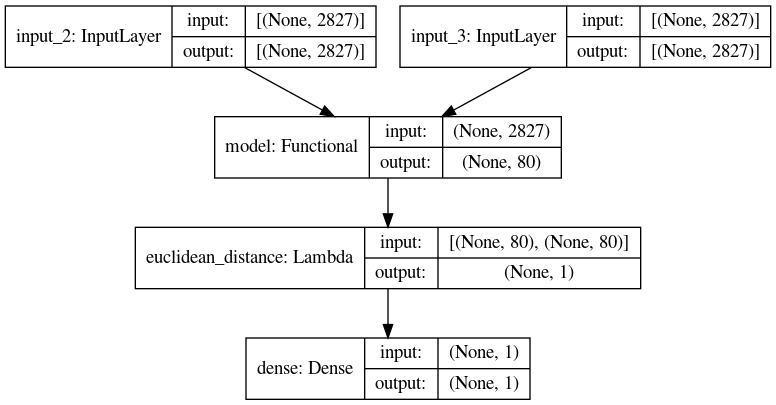

Epoch 1/5
410/410 [==============================] - 5588s 14s/step - loss: 0.6923 - accuracy: 0.5017 - recall: 0.9955 - precision: 0.5008 - microf1: 0.6637 - macrof1: 0.6637 - val_loss: 0.6612 - val_accuracy: 0.7340 - val_recall: 0.7789 - val_precision: 0.9123 - val_microf1: 0.8390 - val_macrof1: 0.8390
Epoch 2/5
410/410 [==============================] - 5578s 14s/step - loss: 0.6824 - accuracy: 0.5504 - recall: 0.8752 - precision: 0.5376 - microf1: 0.6600 - macrof1: 0.6600 - val_loss: 0.6494 - val_accuracy: 0.6011 - val_recall: 0.6046 - val_precision: 0.9275 - val_microf1: 0.7297 - val_macrof1: 0.7297
Epoch 3/5
410/410 [==============================] - 5622s 14s/step - loss: 0.6772 - accuracy: 0.6018 - recall: 0.6445 - precision: 0.5981 - microf1: 0.6166 - macrof1: 0.6166 - val_loss: 0.6509 - val_accuracy: 0.6001 - val_recall: 0.6009 - val_precision: 0.9288 - val_microf1: 0.7277 - val_macrof1: 0.7277
Epoch 4/5
410/410 [==============================] - 5627s 14s/step - loss: 0.6745

In [ ]:
#split data
X_train,Y_train,X_dev,Y_dev,X_test,Y_test = split_by_id(file = '../input/zero-shot-legal-03042021/filt_df.pickle')
    
#process data
train_seqs1, train_seqs2, dev_seqs1, dev_seqs2, test_seqs1, test_seqs2, max_len, tokenizer = process_input_combined(NUM_WORDS, X_train, X_dev, X_test)
    
#load embedding
embedding_matrix =  load_fasttext_fast(tokenizer.word_index,NUM_WORDS,embedding_size) 
 
train_generator = multi_input_proportional_generator([train_seqs1, train_seqs2], Y_train, p=[0.5, 0.5], batch_size=BATCH_SIZE)
validation_generator = multi_input_proportional_generator([dev_seqs1, dev_seqs2], Y_dev, batch_size=BATCH_SIZE)
    
"""sharing weight layer"""
gru_model = gru_model(max_len,embedding_matrix,embedding_size)
    
"""2 input"""
#input & output
input_layer = Input(shape=(max_len,))
input_layer2 = Input(shape=(max_len,))

left_output = gru_model(input_layer)
right_output = gru_model(input_layer2)


#distance function
merged = Lambda(euclidean_distance, name='euclidean_distance')\
([left_output, right_output])
pred =  tf.keras.layers.Dense(1, activation='sigmoid')(merged)

gru_model = tf.keras.Model(inputs=[input_layer, input_layer2], outputs=pred)
  
opt = tf.keras.optimizers.Adam(
learning_rate=lr,
name='Adam')

gru_model.compile(optimizer = opt,loss="binary_crossentropy", metrics=['accuracy', recall, precision, microf1, macrof1])
gru_model.summary()

tf.keras.utils.plot_model(gru_model, show_shapes=True,to_file='model.png')  
display_png(Image('model.png'))  

num_batches = int(len(train_seqs1)/BATCH_SIZE)
    
history = gru_model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=num_batches,validation_data=validation_generator,validation_steps=num_batches,verbose = 1)

print("Evaluation")

predictions=gru_model.predict([test_seqs1,test_seqs2], verbose=1)
y_pred = [lst[0] for lst in predictions ]
y_true = Y_test
legal_encoded_seq = X_test[:, 2]



In [ ]:
y_pred = [1 if lst[0] > 0.5 else 0  for lst in predictions ]                                                            

In [ ]:
predictions

array([[0.59821725],
       [0.4500785 ],
       [0.438361  ],
       ...,
       [0.4398219 ],
       [0.44009322],
       [0.4398124 ]], dtype=float32)

In [ ]:
evaluation = evaluate(y_true,y_pred,legal_encoded_seq)

print(json.dumps(evaluation, indent=4))

{
    "251": {
        "f1": 0.3162393162393162,
        "precision": 0.18781725888324874,
        "recall": 1.0
    },
    "135": {
        "f1": 0.06557377049180328,
        "precision": 0.5,
        "recall": 0.03508771929824561
    },
    "202": {
        "f1": 0.0,
        "precision": 0.0,
        "recall": 0.0
    },
    "692": {
        "f1": 0.25406203840472674,
        "precision": 0.1455160744500846,
        "recall": 1.0
    },
    "154": {
        "f1": 0.18740399385560674,
        "precision": 0.10338983050847457,
        "recall": 1.0
    },
    "715": {
        "f1": 0.0,
        "precision": 0.0,
        "recall": 0.0
    },
    "704": {
        "f1": 0.26686656671664166,
        "precision": 0.15424610051993068,
        "recall": 0.9888888888888889
    },
    "688": {
        "f1": 0.0,
        "precision": 0.0,
        "recall": 0.0
    },
    "417": {
        "f1": 0.0,
        "precision": 0.0,
        "recall": 0.0
    },
    "100": {
        "f1": 0.0,
        "p

# Result

In [ ]:
print(classification_report(Y_test,y_pred))                   

              precision    recall  f1-score   support

           0       0.94      0.62      0.75      5349
           1       0.15      0.62      0.24       561

    accuracy                           0.62      5910
   macro avg       0.54      0.62      0.49      5910
weighted avg       0.86      0.62      0.70      5910

